 # XGBoost - Classification

**Using Optuna for hyper-parameter search  to predict TPSA from morphology profiles**

 ## Initialization

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## imports 

In [126]:
# Models
import os, sys
import math
import pickle
import itertools
import copy 
import joblib
import logging 
# from multiprocessing import Pool, process
from datetime import datetime, time
from collections import defaultdict
from collections.abc import Iterator

if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)

import numpy as np
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

import pandas as pd
pd.options.display.width = 170

import scipy.stats as sps 
import sklearn.metrics as skm
import matplotlib.pyplot as plt

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore')

from utils import display_gpu_info, display_gpu_device_info
from utils_cellpainting import *
from utils_ml import model_selection 

# os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

setup_logging()
logging.info(f" 1/7- engine connected")
# logging.warning(f" 1/7- engine connected")
# logging.error(f" 1/7- engine connected")
# logging.critical(f" 1/7- engine connected")
# print(logging.NOTSET, logging.DEBUG,  logging.INFO, logging.WARN, logging.WARNING, logging.ERROR, logging.CRITICAL,  logging.FATAL)

print()
for time_fmt in ['%x %X', '%X %x %Z', '%X.%f', '%D-%X.%f', '%Y-%m-%d %H:%M:%S.%f']:
    cmd_string = f"datetime.now().strftime('{time_fmt}')"
    print(f" {cmd_string:50s}  : {datetime.now().strftime(time_fmt)}")

# display_gpu_info()

2024-04-25 11:24:50,947 - INFO: -  1/7- engine connected


['/tmp/dask-scratch-space', '/tmp/dask-scratch-space/scheduler-x8ijkd22', './src', '/home/kevin/WSL-shared/Cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']

 datetime.now().strftime('%x %X')                    : 04/25/24 11:24:50
 datetime.now().strftime('%X %x %Z')                 : 11:24:50 04/25/24 
 datetime.now().strftime('%X.%f')                    : 11:24:50.948616
 datetime.now().strftime('%D-%X.%f')                 : 04/25/24-11:24:50.948629
 datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')     : 2024-04-25 11:24:50.948639


In [3]:
import optuna
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask_cuda import LocalCUDACluster
import dask_ml.model_selection as dcv

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import sklearn.metrics as skm

# from dask_ml.model_selection import train_test_split
# from dask_ml.model_selection import GridSearchCV, IncrementalSearchCV, HyperbandSearchCV
# from dask_ml.metrics import mean_squared_error, r2_score, mean_squared_log_error

## Helper Functions

In [4]:
def train_model(iter_files, metric_keys = None, study_name = "", trial_num = 0, save = False, 
                **model_params):
    metrics_hist = defaultdict(list)
    my_model = None
    
    for i, ((X_train,y_train), (X_val, y_val)) in enumerate(iter_files):
        logging.info(f"CrossValidation split #{i}")
        logging.info(f"Building training & validation DMatrix...")
        
        d_train = xgb.dask.DaskDMatrix( client, X_train, y_train)      
        d_val = xgb.dask.DaskDMatrix(client, X_val, y_val)
        
        logging.info(f"Training model...")
        # booster_model = my_model['booster'] if my_model is not None else None
        my_model = xgb.dask.train(
            None,  
            model_params, 
            d_train,
            # xgb_model = booster_model,
            num_boost_round=1000,
            evals=[(d_train, "train"), (d_val, "test")],
            verbose_eval=False,
            early_stopping_rounds = 50
        )
        # logging.info(f"Training model...Completed")
        
        logging.info(f"Running model on test data...")
        y_pred = xgb.dask.predict(client, my_model, d_val).compute()      
        y_true = y_val.compute().to_numpy().squeeze()

        # Compute predictions and mean squared error for this iteration
        logging.info(f"Calculating metrics...")
        iter_metrics = compute_classification_metrics(my_model, y_true, y_pred)
        logging.info(f"Calculating metrics...Completed")
        
        print("-" * 80)            
        for key in metric_keys:
            metrics_hist[key].append(iter_metrics[key])
            print(f" {key:20s}: {iter_metrics[key]:9.5f}")
        print("-" * 80)            
        
        del d_train, d_val, X_train, y_train, X_val, y_val, y_true, y_pred

    ## End of loop  
    return my_model, metrics_hist


def objective(trial, disp_params = True, save = True):
    metric_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
                    "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]    
    CV_FOLDS = 5
    obj = "binary:logistic"
    eval_metric =["auc", "logloss"]
    
    study_params = propose_parameters(trial, obj, eval_metric)   
    study_params = {"booster"      : "gbtree",
                    "device"       : "gpu",
                    # "objective"    :  "binary:logistic",
                    # "eval_metric"  :  ["auc", "logloss"],
                    "verbosity"    : 0, 
                    "disable_default_eval_metric" : False,
                    ** study_params}
    print('-'*80)
    print(f" Training model (trial #{trial.number}) ")
    print('-'*80)

    if disp_params:
        print(f" Parameters:")
        for k, v in study_params.items():
            print(f"  {k:30s} {v}")
            
    iter_files = make_cv_splits_2(input_file_list, n_folds=CV_FOLDS, y_columns=y_columns)
    model, metrics =  train_model(iter_files, metric_keys = metric_keys, 
                                  study_name = study.study_name,
                                  trial_num = trial.number,
                                  save = True,
                                  ** study_params)

    print_metric_hist(metrics)
    print(f" model best score    :  {model['booster'].best_score}")
    print(f" model best iteration:  {model['booster'].best_iteration}")
    
    if save:
        save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
        print(f" Save model to : {save_as_filename}")
        model['booster'].save_model(save_as_filename)    

    r1 = np.array(metrics['val_auc']).mean()
    r2 = np.array(metrics['val_logloss']).mean()
    del model, metrics 
    return r1,r2 

## Datasets

In [5]:
prefix = '' ### Target-2' , 'MOA'
input_path ="./metadata/"
output_path ="./output_11102023"
prefix_lc = prefix.lower().replace('-', '_')
CSV = '.csv'
x = 999

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}/compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFile         = f"{output_path}{prefix_lc}/profiles/compound_profiles_2samples"
CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}/compound_extended_metadata_samples.csv"
profileInputFiles                   = "./output_11102023/profiles/compound_profiles_2samples_{0:03d}.csv"
binned_2SampleProfileFiles          = "./output_11102023/2_sample_profiles/binned_2sample_profiles_{0:03d}.csv"
binned_3SampleProfileFiles          = "./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv"
trainingMetrics                     = f"{output_path}{prefix_lc}/training_metrics.pkl"
profileMetadataFile                 = f"{input_path}profile_metadata.pkl"

print()
print(f" Compound Extended Metadata 2 SampleFile  : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV     : {CompoundProfiles2SampleFile}")
print(f" ")
print(f" profiles Metadata File                   : {profileMetadataFile}")
print(f" ")
print(f" profileInputFiles                        : {profileInputFiles}")
print(f" binned_2ProfileFiles                     : {binned_2SampleProfileFiles}")
print(f" binned_3ProfileFiles                     : {binned_3SampleProfileFiles}")
print(f" training metrics                         : {trainingMetrics}")


 Compound Extended Metadata 2 SampleFile  : ./output_11102023/compound_extended_metadata_2samples.csv
 Compound Profiles 2 Samples File CSV     : ./output_11102023/profiles/compound_profiles_2samples
 
 profiles Metadata File                   : ./metadata/profile_metadata.pkl
 
 profileInputFiles                        : ./output_11102023/profiles/compound_profiles_2samples_{0:03d}.csv
 binned_2ProfileFiles                     : ./output_11102023/2_sample_profiles/binned_2sample_profiles_{0:03d}.csv
 binned_3ProfileFiles                     : ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv
 training metrics                         : ./output_11102023/training_metrics.pkl


## Read Features metadata file

In [6]:
print(f" Features select file:  {profileMetadataFile}")

 Features select file:  ./metadata/profile_metadata.pkl


In [7]:
with open(profileMetadataFile, 'rb') as f: 
    pickle_data = pickle.load(f)
    
pickle_data.keys()

# COMPOUND_PROFILE_COLUMNS = pickle_data['all_profile_columns']  ## 3672 
COMPOUND_PROFILE_COLUMNS = pickle_data['metadata_columns']['MetadataNames'] + sorted(list(pickle_data['selected_columns']['selected']))  ## 1482

metadata_categorical_columns = set(pickle_data['metadata_columns']['MetadataCategoricalColumns'])
metadata_categorical_columns_dtype = pickle_data['metadata_columns']['MetadataCategoricalColumns']

metadata_float_columns =  set(pickle_data['metadata_columns']['MetadataFloatColumns'])
metadata_float_columns_dtype =  pickle_data['metadata_columns']['MetadataFloatColumns']

metadata_integer_columns =  set(pickle_data['metadata_columns']['MetadataIntegerColumns'])
metadata_integer_columns_dtype =  pickle_data['metadata_columns']['MetadataIntegerColumns']

metadata_numeric_columns =  set(pickle_data['metadata_columns']['MetadataNumericColumns'])
metadata_numeric_columns_dtype =  pickle_data['metadata_columns']['MetadataNumericColumns']


X_columns = pickle_data['selected_columns']['selected']
X_columns_dtype = {x: np.float32 for x in X_columns}

y_columns = set(["Metadata_Permiation"])
y_columns_dtype = {x: np.int64 for x in y_columns} ## "Metadata_log10TPSA":np.dtype('float64')}

Xy_columns = list(y_columns | X_columns)
Xy_columns_dtype = y_columns_dtype | X_columns_dtype
 

dict_keys(['all_profile_columns', 'metadata_columns', 'selected_columns', 'parquet_columns'])

### Display metadata info and constants used 

In [8]:
disp_metadata_file(pickle_data, COMPOUND_PROFILE_COLUMNS)

print(f" len(X_columms)                ({len(X_columns):4d})")
print(f" len(y_columms)                ({len(y_columns):4d}) {y_columns}")
print(f" len(Xy_columms)               ({len(Xy_columns)}) {list(Xy_columns)[:3]}")
print(f" len(Xy_columms_dtype)         ({len(Xy_columns)}) {list(Xy_columns_dtype)[:3]}")


--------------------------------------------------------------------------------
 all_profile_columns & COMPOUND_PROFILE_COLUMNS
--------------------------------------------------------------------------------
  Len all_profile_columns        : 3672
  Len COMPOUND_PROFILE_COLUMNS   : 1482

  all_profile_columns[:10]       : ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA']
  COMPOUND_PROFILE_COLUMNS[:10]  : ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA']

  all_profile_columns[10:15]     : ['Metadata_Permiation', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y']
  COMPOUND_PROFILE_COLUMNS[10:15]: ['Metadata_Permiation', 'Cells_AreaSh

In [9]:
# print(f" len(label_columms_dtype)     : {len(label_columns_dtype)} ")
# print(f" len(X_columms_dtype)         : {len(X_columns_dtype)}")
# print(f" len(X_columms_dtype)           : {len(X_columns_dtype)}   {X_columns_dtype}")
# print(f" len(y_columms_dtype)         : {len(y_columns_dtype)}")
# print(f" len(Xy_columms_dtype)        : {len(Xy_columns_dtype)}")
# print(f" len(all_columms_dtype)       : {len(all_columns_dtype)} ")
# del all_columns_dtype
# for k  in sorted(all_columns_dtype.keys()):
#     print(f" {k:60s}  {all_columns_dtype[k]}")
# Xy_columns_dtype

In [10]:
# profile_file= "./output_11102023/profiles/compound_profiles_2samples_002.csv"
# df_profiles = pd.read_csv(profile_file_001, header=0, names = all_columns, usecols=Xy_columns, dtype= Xy_columns_dtype, nrows =5)   
# df_profiles = pd.read_csv(profile_file, header=0, names = profileColumnNames, usecols=Xy_columns, dtype= Xy_columns_dtype, nrows =5)   

## Create dask cluster and client 

In [11]:
!nvidia-smi

Wed Apr 24 10:43:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN Xp                Off |   00000000:09:00.0 Off |                  N/A |
| 23%   31C    P8              9W /  250W |       4MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [107]:
try:
    cluster.close()
    del cluster
except Exception as e:
    print("Cluster doesn't exist")
else:
    print("Cluster close succeeded")

Cluster close succeeded


In [108]:
n_workers = 3
n_threads = 2
cuda_visible_devices = [0,1,2]
cluster = LocalCUDACluster( CUDA_VISIBLE_DEVICES=[0,1,2], n_workers=n_workers, threads_per_worker= n_threads, memory_limit='6GB', silence_logs = logging.WARNING)
# cluster = LocalCluster("Kevins_Cluster", n_workers=n_workers, threads_per_worker= n_threads, silence_logs = logging.WARNING)
print(f" Cluster dashboard link : {cluster.dashboard_link}")

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


 Cluster dashboard link : http://127.0.0.1:8787/status


In [109]:
# print(cluster)
# print(f" Cluster dashboard link : {cluster.dashboard_link}")
# cluster.workers[2].restart
# cluster.start_worker
# cluster.worker_spec
# cluster.scale(3)

In [110]:
try:
    client.close()
    del client
except Exception as e:
    print(" *** Client close failed *** ")
else:
    print(" *** Client close succeeded *** ")
finally:
    client = Client(cluster)    
    print(f"\n *** Client created - {client.status} ")
    client

 *** Client close succeeded *** 

 *** Client created - running 


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 16.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37217,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 16.76 GiB
Comm: tcp://127.0.0.1:38909,Total threads: 2
Dashboard: http://127.0.0.1:35377/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:45569,


# Use Optuna for hyper-parameter search

#### Save column hader names for csv file as this is an old file 

In [16]:
# INPUT_FILE = "./output_11102023/2_sample_profiles/binned_2sample_profiles_w_header_000.csv"
# print(f"Reading {INPUT_FILE}")
# df = pd.read_csv(INPUT_FILE)
# df.info()
# df.iloc[:5,:15]
# df.loc[0]
# header_3681 = df.columns.to_list()
# df_header = pd.DataFrame(data=None, columns = df.columns)
# df_header
# df_header.to_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_3681_header_info.csv", index = False )

# INPUT_FILE = './output_11102023/2_sample_profiles/2sample_profiles_1482_HashOrder.csv.gz'
# print(f"Reading {INPUT_FILE}")
# df = pd.read_csv(INPUT_FILE, nrows = 5)

# df.info()
# df.iloc[:5,:15]
# df.loc[0]
# header_1482 = df.columns.to_list()
# df_header = pd.DataFrame(data=None, columns = df.columns)
# df_header
# df_header.to_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_1482_header_info.csv", index = False )

### Setup ML env

In [17]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 

'2.0.3'

## Load Datafiles 

  ### Load header information for compound_profile datasets

In [18]:

# df_header = pd.read_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_3681_header_info.csv")
# df_header
# COMPOUND_PROFILE_COLUMNS_3681 = df_header.columns.to_list()
# len(COMPOUND_PROFILE_COLUMNS_3681)

In [19]:
# df_profiles = read_cell_profiles(input_files[i], names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_profiles = read_cell_profiles(training_files, names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# file_idxs = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# TRAINING_FILES = {0, 1, 2, 4, 5, 6, 7, 8, 9, 11}
# TEST_FILES = {3, 10}
TRAINING_FILES = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
TEST_FILES = {15}
binnedProfileFiles = binned_3SampleProfileFiles
print(binnedProfileFiles)

./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv


In [20]:
input_file_list = read_binned_profile_files(file_idxs = TRAINING_FILES, 
                                            filename = binnedProfileFiles,
                                            names = COMPOUND_PROFILE_COLUMNS, 
                                            # names = COMPOUND_PROFILE_COLUMNS_3681, 
                                            usecols = Xy_columns,
                                            dtype = Xy_columns_dtype,
                                            index_cols = False,)

2024-04-24 10:43:20,099 - INFO: -  Read profiles file ...


 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_000.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_001.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_002.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_003.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_004.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_005.csv    {'index_cols': F

2024-04-24 10:43:23,266 - INFO: -  Read profiles file ... complete


 Reading ALL  rows - Number of partitions:  9   



## Load study

  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/optuna_data.db`
  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/example.db`
  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/example_copy.db`

In [21]:
# storage = "sqlite:///example.db"
# storage_copy = "sqlite:///example_copy.db"
storage_instance = "sqlite:///optuna_database.db"
# study_name ="classification-2SampleStudy-Apr24"
study_name ="classification-3SampleStudy-Apr24"
# study_name="classification-study-1"

## https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RetryFailedTrialCallback.html
#
# from optuna.storages import RetryFailedTrialCallback
#
# storage_instance = optuna.storages.RDBStorage(
#     url=storage_copy,
#     heartbeat_interval=60,
#     grace_period=120,
#     failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
# )
# storage_instance

In [22]:
# resp = input(f" Delete study {study_name} ?")
# if resp.lower() in ['yes' ,'y']:
#     print(' You responsed yes')
#     try:
#         optuna.delete_study(storage=storage_instance, study_name=study_name)
#         print("delete successful")
#     except Exception as e:
#         print("delete failed")
# else:
#     print(f" {study_name} will be kept")

study = optuna.create_study(storage=storage_instance,
                            study_name=study_name,
                            directions=["maximize","minimize"], 
                            load_if_exists=True)
study.set_metric_names(["roc_auc", "logloss"])

[I 2024-04-24 10:56:56,096] Using an existing study with name 'classification-3SampleStudy-Apr24' instead of creating a new one.


In [23]:
# start = datetime.now()
# study  = optuna.load_study(study_name= study_name , storage=storage_instance)
# print(f"Total time:  {datetime.now() - start}")

In [26]:
disp_study_history(study)

 classification-3SampleStudy-Apr24  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-04-23   23:38:03 - 23:50:34    1      0.56071        0.55998    
Trial #: 1    2024-04-23   23:50:34 - 00:04:55    1      0.62853        0.35265    
Trial #: 2    2024-04-24   00:04:56 - 00:19:41    1      0.53452        5.76593    
Trial #: 3    2024-04-24   00:40:48 - 00:40:48    3          *** FAILED ***        
Trial #: 4    2024-04-24   00:41:55 - 00:50:55    1      0.59665        0.36301    
Trial #: 5    2024-04-24   00:50:55 - 01:00:21    1      0.54799        1.08768    
Trial #: 6    2024-04-24   01:00:22 - 01:08:36    1      0.51181        1.24476    
Trial #: 7    2024-04-24   01:08:37 - 01:17:35    1      0.62289        0.35346    
Trial #: 8    2024-04-24   10:57:05 -

In [58]:
disp_study_history(study)

 classification-study-1-clone  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-02-11   15:31:07 - 16:38:29    1      0.62593        0.35270    
Trial #: 1    2024-02-11   21:50:47 - 22:14:47    1      0.60966        0.35607    
Trial #: 2    2024-02-11   23:21:11 - 00:01:20    1      0.61561        0.36063    
Trial #: 3    2024-02-12   00:01:21 - 00:39:17    1      0.60933        0.35866    
Trial #: 4    2024-02-12   00:39:18 - 00:56:58    1      0.59683        0.36285    
Trial #: 5    2024-02-12   01:55:54 - 02:12:44    1      0.55990        0.56057    
Trial #: 6    2024-02-12   02:12:45 - 02:29:49    1      0.59509        0.36394    
Trial #: 7    2024-02-12   02:29:50 - 03:59:12    1      0.61147        0.37472    
Trial #: 8    2024-02-12   03:59:13 - 04:4

## Run studies

In [25]:
start = datetime.now()

study.optimize(objective, n_trials=4, timeout=3600*7, gc_after_trial=True, show_progress_bar=False)

print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #8) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.2971545294100626
  gamma                          6.919884299978366
  max_depth                      9
  min_child_weight               6.150376989728685
  max_delta_step                 9.906095553994511
  subsample                      0.8671871151894116
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.8596681051267068
  colsample_bynode               0.7908527359471309
  lambda                         

2024-04-24 10:57:14,445 - INFO: - CrossValidation split #0
2024-04-24 10:57:14,446 - INFO: - Building training & validation DMatrix...
2024-04-24 10:58:04,605 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 10:58:05,034 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 10:58:05,580 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 10:58:05,887 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-24 10:58:05,964 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 10:58:06,302 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-24 10:58:06,327 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.94223
 train_logloss       :   0.23593
 val_auc             :   0.58827
 val_logloss         :   0.36938
 roc_auc             :   0.58827
 logloss             :   0.36938
 accuracy            :   0.88024
 bal_acc             :   0.01444
 top_k_acc           :   1.00000
 F1_score            :   0.03662
 map                 :   0.17143
 pearson_corr        :   0.12205
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-04-24 10:59:14,968 - INFO: - CrossValidation split #1
2024-04-24 10:59:14,971 - INFO: - Building training & validation DMatrix...
2024-04-24 11:00:25,976 - INFO: - Training model...
2024-04-24 11:00:25,984 - INFO: - start listen on 10.91.28.16:39241
[11:00:26] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:00:26] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:00:26] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:00:26,032 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:00:52,768 - INFO: - @tracker All nodes finishes job
2024-04-24 11:00:53,003 - INFO: - Running model on test data...
2024-04-24 11:01:08,157 - INFO: - Calculating metrics...
2024-04-24 11:01:08,251 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.94339
 train_logloss       :   0.23541
 val_auc             :   0.60044
 val_logloss         :   0.36546
 roc_auc             :   0.60046
 logloss             :   0.36546
 accuracy            :   0.88032
 bal_acc             :   0.01563
 top_k_acc           :   1.00000
 F1_score            :   0.03988
 map                 :   0.17498
 pearson_corr        :   0.13023
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-04-24 11:01:17,252 - INFO: - CrossValidation split #2
2024-04-24 11:01:17,254 - INFO: - Building training & validation DMatrix...
2024-04-24 11:02:29,763 - INFO: - Training model...
2024-04-24 11:02:29,771 - INFO: - start listen on 10.91.28.16:35647
[11:02:29] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:02:29] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:02:29] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:02:29,812 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:02:57,329 - INFO: - @tracker All nodes finishes job
2024-04-24 11:02:57,548 - INFO: - Running model on test data...
2024-04-24 11:03:12,833 - INFO: - Calculating metrics...
2024-04-24 11:03:12,924 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.94773
 train_logloss       :   0.22937
 val_auc             :   0.60352
 val_logloss         :   0.37302
 roc_auc             :   0.60342
 logloss             :   0.37302
 accuracy            :   0.87731
 bal_acc             :   0.01833
 top_k_acc           :   1.00000
 F1_score            :   0.04376
 map                 :   0.18782
 pearson_corr        :   0.14281
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-04-24 11:03:21,826 - INFO: - CrossValidation split #3
2024-04-24 11:03:21,827 - INFO: - Building training & validation DMatrix...
2024-04-24 11:04:34,690 - INFO: - Training model...
2024-04-24 11:04:34,700 - INFO: - start listen on 10.91.28.16:46021
[11:04:34] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:04:34] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:04:34] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:04:34,750 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:05:01,012 - INFO: - @tracker All nodes finishes job
2024-04-24 11:05:01,225 - INFO: - Running model on test data...
2024-04-24 11:05:16,466 - INFO: - Calculating metrics...
2024-04-24 11:05:16,578 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.94248
 train_logloss       :   0.23552
 val_auc             :   0.59077
 val_logloss         :   0.37194
 roc_auc             :   0.59072
 logloss             :   0.37194
 accuracy            :   0.87890
 bal_acc             :   0.01605
 top_k_acc           :   1.00000
 F1_score            :   0.03952
 map                 :   0.17511
 pearson_corr        :   0.12461
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-04-24 11:05:26,109 - INFO: - CrossValidation split #4
2024-04-24 11:05:26,110 - INFO: - Building training & validation DMatrix...
2024-04-24 11:06:19,677 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:20,134 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:20,615 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:21,074 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:21,594 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:22,046 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:06:22,481 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.94289
 train_logloss       :   0.23393
 val_auc             :   0.59466
 val_logloss         :   0.37468
 roc_auc             :   0.59464
 logloss             :   0.37468
 accuracy            :   0.87755
 bal_acc             :   0.01809
 top_k_acc           :   1.00000
 F1_score            :   0.04354
 map                 :   0.17785
 pearson_corr        :   0.12768
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.94374 +/- 0.00203
 train_logloss             0.23403 +/- 0.00243
 val_auc                   0.59553 +/- 0.00573
 val_logloss               0.37089 +/- 0.00322
 roc_auc                   0.59550 +/- 0.00571
 logloss                   0.37089 +/- 0.00322
 accuracy                  0.87887 +/- 0.00128
 bal_acc                   0.016

2024-04-24 11:07:33,151 - INFO: - CrossValidation split #0
2024-04-24 11:07:33,153 - INFO: - Building training & validation DMatrix...
2024-04-24 11:07:34,744 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:35,891 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:36,238 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:36,612 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:38,342 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:39,280 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:07:39,682 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.97843
 train_logloss       :   0.24707
 val_auc             :   0.62254
 val_logloss         :   0.35020
 roc_auc             :   0.62257
 logloss             :   0.35020
 accuracy            :   0.88264
 bal_acc             :   0.00538
 top_k_acc           :   1.00000
 F1_score            :   0.01140
 map                 :   0.20353
 pearson_corr        :   0.17518
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-04-24 11:11:37,193 - INFO: - CrossValidation split #1
2024-04-24 11:11:37,194 - INFO: - Building training & validation DMatrix...
2024-04-24 11:12:51,621 - INFO: - Training model...
2024-04-24 11:12:51,630 - INFO: - start listen on 10.91.28.16:50585
[11:12:51] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:12:51] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:12:51] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:12:51,674 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:16:09,104 - INFO: - @tracker All nodes finishes job
2024-04-24 11:16:09,429 - INFO: - Running model on test data...
2024-04-24 11:16:24,840 - INFO: - Calculating metrics...
2024-04-24 11:16:24,930 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.97754
 train_logloss       :   0.24842
 val_auc             :   0.62722
 val_logloss         :   0.34879
 roc_auc             :   0.62707
 logloss             :   0.34879
 accuracy            :   0.88287
 bal_acc             :   0.00779
 top_k_acc           :   1.00000
 F1_score            :   0.01735
 map                 :   0.20257
 pearson_corr        :   0.17573
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-04-24 11:16:34,233 - INFO: - CrossValidation split #2
2024-04-24 11:16:34,234 - INFO: - Building training & validation DMatrix...
2024-04-24 11:17:48,478 - INFO: - Training model...
2024-04-24 11:17:48,487 - INFO: - start listen on 10.91.28.16:44427
[11:17:48] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:17:48] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:17:48] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:17:48,527 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:20:52,822 - INFO: - @tracker All nodes finishes job
2024-04-24 11:20:53,121 - INFO: - Running model on test data...
2024-04-24 11:21:08,985 - INFO: - Calculating metrics...
2024-04-24 11:21:09,083 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.97537
 train_logloss       :   0.25160
 val_auc             :   0.63544
 val_logloss         :   0.35453
 roc_auc             :   0.63527
 logloss             :   0.35453
 accuracy            :   0.87911
 bal_acc             :   0.00627
 top_k_acc           :   1.00000
 F1_score            :   0.01342
 map                 :   0.21982
 pearson_corr        :   0.19337
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-04-24 11:21:17,655 - INFO: - CrossValidation split #3
2024-04-24 11:21:17,657 - INFO: - Building training & validation DMatrix...
2024-04-24 11:22:33,640 - INFO: - Training model...
2024-04-24 11:22:33,648 - INFO: - start listen on 10.91.28.16:58565
[11:22:33] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:22:33] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:22:33] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:22:33,687 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:25:47,990 - INFO: - @tracker All nodes finishes job
2024-04-24 11:25:48,309 - INFO: - Running model on test data...
2024-04-24 11:26:03,873 - INFO: - Calculating metrics...
2024-04-24 11:26:03,965 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.97748
 train_logloss       :   0.24800
 val_auc             :   0.62843
 val_logloss         :   0.35279
 roc_auc             :   0.62850
 logloss             :   0.35279
 accuracy            :   0.88089
 bal_acc             :   0.00594
 top_k_acc           :   1.00000
 F1_score            :   0.01300
 map                 :   0.20471
 pearson_corr        :   0.17590
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-04-24 11:26:12,887 - INFO: - CrossValidation split #4
2024-04-24 11:26:12,889 - INFO: - Building training & validation DMatrix...
2024-04-24 11:26:15,658 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:26:17,976 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:26:19,869 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:26:22,140 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:26:24,287 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:26:26,602 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 11:26:28,943 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.97733
 train_logloss       :   0.24882
 val_auc             :   0.62842
 val_logloss         :   0.35583
 roc_auc             :   0.62837
 logloss             :   0.35583
 accuracy            :   0.87908
 bal_acc             :   0.00366
 top_k_acc           :   1.00000
 F1_score            :   0.00854
 map                 :   0.20808
 pearson_corr        :   0.17817
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.97723 +/- 0.00101
 train_logloss             0.24878 +/- 0.00152
 val_auc                   0.62841 +/- 0.00413
 val_logloss               0.35243 +/- 0.00262
 roc_auc                   0.62836 +/- 0.00408
 logloss                   0.35243 +/- 0.00262
 accuracy                  0.88092 +/- 0.00164
 bal_acc                   0.005

[I 2024-04-24 11:30:58,779] Trial 9 finished with values: {'roc_auc': 0.6284121684126462, 'logloss': 0.35242719786596105} and parameters: {'learning_rate': 0.028438450576128264, 'min_split_loss': 0.8571213408681211, 'max_depth': 10, 'min_child_weight': 8.66783339115337, 'max_delta_step': 8.251511503793736, 'subsample': 0.7671210262230865, 'colsample_bylevel': 0.5644981249764368, 'colsample_bynode': 0.700592712163171}. 


--------------------------------------------------------------------------------
 Training model (trial #10) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  3.214811695174208
  gamma                          8.456958109704582
  max_depth                      2
  min_child_weight               6.732749888857212
  max_delta_step                 4.961893878697422
  subsample                      0.41950139285270105
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6611178001280926
  colsample_bynode               0.9584371861579395
  lambda                        

2024-04-24 11:31:08,105 - INFO: - CrossValidation split #0
2024-04-24 11:31:08,107 - INFO: - Building training & validation DMatrix...
2024-04-24 11:31:10,753 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-24 11:31:11,084 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-24 11:31:11,425 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-24 11:32:22,011 - INFO: - Training model...
2024-04-24 11:32:22,019 - INFO: - start listen on 10.91.28.16:52599
[11:32:22] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:32:22] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:32:22] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:32:22,057 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:32:29,415 - INFO: - @tracker All nodes finishes job
2024-

--------------------------------------------------------------------------------
 train_auc           :   0.48957
 train_logloss       :   1.72353
 val_auc             :   0.48660
 val_logloss         :   1.71108
 roc_auc             :   0.48666
 logloss             :   1.54900
 accuracy            :   0.86245
 bal_acc             :   0.03277
 top_k_acc           :   1.00000
 F1_score            :   0.09840
 map                 :   0.12116
 pearson_corr        :   0.05948
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-04-24 11:32:53,241 - INFO: - CrossValidation split #1
2024-04-24 11:32:53,242 - INFO: - Building training & validation DMatrix...
2024-04-24 11:34:07,889 - INFO: - Training model...
2024-04-24 11:34:07,900 - INFO: - start listen on 10.91.28.16:51959
[11:34:07] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:34:07] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:34:07] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:34:07,940 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:34:15,224 - INFO: - @tracker All nodes finishes job
2024-04-24 11:34:15,420 - INFO: - Running model on test data...
2024-04-24 11:34:30,922 - INFO: - Calculating metrics...
2024-04-24 11:34:30,992 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.49344
 train_logloss       :   1.54813
 val_auc             :   0.49895
 val_logloss         :   1.52545
 roc_auc             :   0.49969
 logloss             :   1.33249
 accuracy            :   0.86223
 bal_acc             :   0.04195
 top_k_acc           :   1.00000
 F1_score            :   0.11344
 map                 :   0.12495
 pearson_corr        :   0.07104
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-04-24 11:34:39,768 - INFO: - CrossValidation split #2
2024-04-24 11:34:39,769 - INFO: - Building training & validation DMatrix...
2024-04-24 11:35:54,965 - INFO: - Training model...
2024-04-24 11:35:54,974 - INFO: - start listen on 10.91.28.16:37087
[11:35:55] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:35:55] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:35:55] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:35:55,016 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:36:02,495 - INFO: - @tracker All nodes finishes job
2024-04-24 11:36:02,668 - INFO: - Running model on test data...
2024-04-24 11:36:18,012 - INFO: - Calculating metrics...
2024-04-24 11:36:18,080 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.49478
 train_logloss       :   1.56913
 val_auc             :   0.49690
 val_logloss         :   1.59600
 roc_auc             :   0.49691
 logloss             :   1.38756
 accuracy            :   0.84854
 bal_acc             :   0.04282
 top_k_acc           :   1.00000
 F1_score            :   0.12539
 map                 :   0.12829
 pearson_corr        :   0.06486
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-04-24 11:36:25,905 - INFO: - CrossValidation split #3
2024-04-24 11:36:25,907 - INFO: - Building training & validation DMatrix...
2024-04-24 11:37:20,597 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:21,219 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:22,033 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:22,599 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:23,166 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:24,114 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 11:37:24,667 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.49579
 train_logloss       :   1.50224
 val_auc             :   0.50294
 val_logloss         :   1.48173
 roc_auc             :   0.50314
 logloss             :   1.36926
 accuracy            :   0.85931
 bal_acc             :   0.04805
 top_k_acc           :   1.00000
 F1_score            :   0.12425
 map                 :   0.12785
 pearson_corr        :   0.07808
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-04-24 11:38:14,364 - INFO: - CrossValidation split #4
2024-04-24 11:38:14,365 - INFO: - Building training & validation DMatrix...
2024-04-24 11:39:30,211 - INFO: - Training model...
2024-04-24 11:39:30,228 - INFO: - start listen on 10.91.28.16:43631
[11:39:30] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:39:30] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:39:30] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:39:30,265 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:39:37,583 - INFO: - @tracker All nodes finishes job
2024-04-24 11:39:37,766 - INFO: - Running model on test data...
2024-04-24 11:39:53,139 - INFO: - Calculating metrics...
2024-04-24 11:39:53,214 - INFO: - Calculating metrics...Completed
[I 2024-04-24 11:39:53,282] Trial 10 finished with values: {'roc_auc': 0.49384734774162753, 'logloss': 1.5593299686218403} and parameters: {'learning_rate': 3.214811695174208, 'min_split_loss': 8.456958109704

--------------------------------------------------------------------------------
 train_auc           :   0.49214
 train_logloss       :   1.45581
 val_auc             :   0.48384
 val_logloss         :   1.48240
 roc_auc             :   0.48363
 logloss             :   1.32032
 accuracy            :   0.86447
 bal_acc             :   0.03436
 top_k_acc           :   1.00000
 F1_score            :   0.09546
 map                 :   0.12478
 pearson_corr        :   0.06684
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.49314 +/- 0.00217
 train_logloss             1.55977 +/- 0.09073
 val_auc                   0.49385 +/- 0.00736
 val_logloss               1.55933 +/- 0.08656
 roc_auc                   0.49401 +/- 0.00756
 logloss                   1.39173 +/- 0.08230
 accuracy                  0.85940 +/- 0.00567
 bal_acc                   0.039

2024-04-24 11:40:02,091 - INFO: - CrossValidation split #0
2024-04-24 11:40:02,093 - INFO: - Building training & validation DMatrix...
2024-04-24 11:41:18,084 - INFO: - Training model...
2024-04-24 11:41:18,091 - INFO: - start listen on 10.91.28.16:40207
[11:41:18] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:41:18] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:41:18] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:41:18,130 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:41:24,930 - INFO: - @tracker All nodes finishes job
2024-04-24 11:41:25,109 - INFO: - Running model on test data...
2024-04-24 11:41:40,375 - INFO: - Calculating metrics...
2024-04-24 11:41:40,441 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.48181
 train_logloss       :  31.49654
 val_auc             :   0.48182
 val_logloss         :  31.55053
 roc_auc             :   0.48195
 logloss             :  13.66147
 accuracy            :   0.14307
 bal_acc             :  -0.03659
 top_k_acc           :   1.00000
 F1_score            :   0.20256
 map                 :   0.11403
 pearson_corr        :  -0.05805
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-04-24 11:41:49,155 - INFO: - CrossValidation split #1
2024-04-24 11:41:49,156 - INFO: - Building training & validation DMatrix...
2024-04-24 11:43:04,795 - INFO: - Training model...
2024-04-24 11:43:04,801 - INFO: - start listen on 10.91.28.16:33577
[11:43:04] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:43:04] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:43:04] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:43:04,837 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:43:11,900 - INFO: - @tracker All nodes finishes job
2024-04-24 11:43:12,072 - INFO: - Running model on test data...
2024-04-24 11:43:27,061 - INFO: - Calculating metrics...
2024-04-24 11:43:27,130 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.48199
 train_logloss       :  31.46715
 val_auc             :   0.48108
 val_logloss         :  31.51916
 roc_auc             :   0.48105
 logloss             :  13.65914
 accuracy            :   0.14322
 bal_acc             :  -0.03863
 top_k_acc           :   1.00000
 F1_score            :   0.20143
 map                 :   0.11343
 pearson_corr        :  -0.06036
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-04-24 11:43:35,946 - INFO: - CrossValidation split #2
2024-04-24 11:43:35,947 - INFO: - Building training & validation DMatrix...
2024-04-24 11:44:51,432 - INFO: - Training model...
2024-04-24 11:44:51,441 - INFO: - start listen on 10.91.28.16:53999
[11:44:51] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:44:51] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:44:51] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:44:51,479 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:44:58,424 - INFO: - @tracker All nodes finishes job
2024-04-24 11:44:58,598 - INFO: - Running model on test data...
2024-04-24 11:45:13,708 - INFO: - Calculating metrics...
2024-04-24 11:45:13,779 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.48236
 train_logloss       :  31.42841
 val_auc             :   0.47975
 val_logloss         :  31.38932
 roc_auc             :   0.47973
 logloss             :  13.63286
 accuracy            :   0.14487
 bal_acc             :  -0.04117
 top_k_acc           :   1.00000
 F1_score            :   0.20712
 map                 :   0.11705
 pearson_corr        :  -0.06643
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-04-24 11:45:21,629 - INFO: - CrossValidation split #3
2024-04-24 11:45:21,632 - INFO: - Building training & validation DMatrix...
2024-04-24 11:46:37,550 - INFO: - Training model...
2024-04-24 11:46:37,558 - INFO: - start listen on 10.91.28.16:43669
[11:46:37] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:46:37] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:46:37] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:46:37,594 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:46:44,576 - INFO: - @tracker All nodes finishes job
2024-04-24 11:46:44,710 - INFO: - Running model on test data...
2024-04-24 11:47:00,136 - INFO: - Calculating metrics...
2024-04-24 11:47:00,211 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.48211
 train_logloss       :  31.40366
 val_auc             :   0.48023
 val_logloss         :  31.47017
 roc_auc             :   0.48023
 logloss             :  13.66910
 accuracy            :   0.14259
 bal_acc             :  -0.04010
 top_k_acc           :   1.00000
 F1_score            :   0.20443
 map                 :   0.11528
 pearson_corr        :  -0.06509
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-04-24 11:47:08,178 - INFO: - CrossValidation split #4
2024-04-24 11:47:08,180 - INFO: - Building training & validation DMatrix...
2024-04-24 11:48:24,441 - INFO: - Training model...
2024-04-24 11:48:24,451 - INFO: - start listen on 10.91.28.16:60995
[11:48:24] task [xgboost.dask-0]:tcp://127.0.0.1:37143 got new rank 0
[11:48:24] task [xgboost.dask-1]:tcp://127.0.0.1:44601 got new rank 1
[11:48:24] task [xgboost.dask-2]:tcp://127.0.0.1:42719 got new rank 2
2024-04-24 11:48:24,490 - INFO: - @tracker All of 3 nodes getting started
2024-04-24 11:48:31,385 - INFO: - @tracker All nodes finishes job
2024-04-24 11:48:31,572 - INFO: - Running model on test data...
2024-04-24 11:48:47,244 - INFO: - Calculating metrics...
2024-04-24 11:48:47,313 - INFO: - Calculating metrics...Completed
[I 2024-04-24 11:48:47,399] Trial 11 finished with values: {'roc_auc': 0.4817748388569691, 'logloss': 31.46756617056883} and parameters: {'learning_rate': 6.941348807217057, 'min_split_loss': 0.59865212989657

--------------------------------------------------------------------------------
 train_auc           :   0.48074
 train_logloss       :  31.55830
 val_auc             :   0.48599
 val_logloss         :  31.40865
 roc_auc             :   0.48600
 logloss             :  13.59148
 accuracy            :   0.14746
 bal_acc             :  -0.02844
 top_k_acc           :   1.00000
 F1_score            :   0.20903
 map                 :   0.11794
 pearson_corr        :  -0.04568
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.48180 +/- 0.00056
 train_logloss            31.47081 +/- 0.05410
 val_auc                   0.48177 +/- 0.00223
 val_logloss              31.46757 +/- 0.06188
 roc_auc                   0.48179 +/- 0.00224
 logloss                  13.64281 +/- 0.02842
 accuracy                  0.14424 +/- 0.00178
 bal_acc                  -0.036

## Enqueue a previous trial and rerun 

In [27]:
disp_study_history(study)

 classification-study-Apr24  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-04-22   20:20:06 - 20:24:06    3          *** FAILED ***        
Trial #: 1    2024-04-22   20:31:37 - 20:34:09    3          *** FAILED ***        
Trial #: 2    2024-04-22   20:38:23 - 20:54:04    3          *** FAILED ***        
Trial #: 3    2024-04-22   21:08:09 - 21:20:12    1      0.53267        0.49278    
Trial #: 4    2024-04-22   21:25:13 - 21:40:33    1      0.53381        3.78331    
Trial #: 5    2024-04-22   21:40:34 - 21:53:39    1      0.53279        5.08449    
Trial #: 6    2024-04-22   21:53:40 - 22:09:39    1      0.58643        0.37186    
Trial #: 7    2024-04-22   22:09:40 - 22:26:56    1      0.62119        0.35337    
Trial #: 8    2024-04-22   22:26:57 - 22:44:

In [39]:
# study.trials_dataframe()

In [231]:
# study.trials[1].params
# study.trials[2].params

In [25]:
# # for i in [3,4,5,6]:
for i in [18]:
    study.enqueue_trial(study.trials[i].params, user_attrs={"memo": f"rerun of trial {i}"})
 

In [26]:
# start = datetime.now()
# study.optimize(objective, n_trials=2, timeout=3600*4, gc_after_trial=True, show_progress_bar=False)
# print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #19) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.01010335601502925
  gamma                          0.2472646534150965
  max_depth                      8
  min_child_weight               6.489942713197961
  max_delta_step                 9.899914342970385
  subsample                      0.9078959875289839
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6706021187887963
  colsample_bynode               0.9887993750054633
  lambda                      

2024-04-23 16:52:24,130 - INFO: - CrossValidation split #0
2024-04-23 16:52:24,131 - INFO: - Building training & validation DMatrix...
2024-04-23 16:53:08,526 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,806 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,966 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,066 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,264 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,865 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:10,234 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95936
 train_logloss       :   0.27141
 val_auc             :   0.62451
 val_logloss         :   0.35518
 roc_auc             :   0.62517
 logloss             :   0.35518
 accuracy            :   0.87945
 bal_acc             :   0.00179
 top_k_acc           :   1.00000
 F1_score            :   0.00434
 map                 :   0.20623
 pearson_corr        :   0.17596
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 16:59:30,219 - INFO: - CrossValidation split #1
2024-04-23 16:59:30,219 - INFO: - Building training & validation DMatrix...
2024-04-23 17:00:30,072 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:30,413 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:31,590 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,362 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,715 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:33,950 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:34,511 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95616
 train_logloss       :   0.27413
 val_auc             :   0.63047
 val_logloss         :   0.35732
 roc_auc             :   0.63110
 logloss             :   0.35732
 accuracy            :   0.87786
 bal_acc             :   0.00178
 top_k_acc           :   1.00000
 F1_score            :   0.00424
 map                 :   0.21082
 pearson_corr        :   0.18227
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:06:29,105 - INFO: - CrossValidation split #2
2024-04-23 17:06:29,106 - INFO: - Building training & validation DMatrix...
2024-04-23 17:08:03,191 - INFO: - Training model...
2024-04-23 17:08:03,204 - INFO: - start listen on 10.91.28.16:52087
[17:08:03] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:08:03] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:08:03] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:08:03,263 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:13:55,353 - INFO: - @tracker All nodes finishes job
2024-04-23 17:13:55,692 - INFO: - Running model on test data...
2024-04-23 17:14:15,667 - INFO: - Calculating metrics...
2024-04-23 17:14:15,735 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.96828
 train_logloss       :   0.26431
 val_auc             :   0.62768
 val_logloss         :   0.34630
 roc_auc             :   0.62924
 logloss             :   0.34630
 accuracy            :   0.88364
 bal_acc             :   0.00358
 top_k_acc           :   1.00000
 F1_score            :   0.00747
 map                 :   0.20960
 pearson_corr        :   0.18676
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:14:22,538 - INFO: - CrossValidation split #3
2024-04-23 17:14:22,539 - INFO: - Building training & validation DMatrix...
2024-04-23 17:14:35,714 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,105 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,499 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:37,722 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:38,583 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,029 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,438 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95796
 train_logloss       :   0.27216
 val_auc             :   0.61741
 val_logloss         :   0.35235
 roc_auc             :   0.61800
 logloss             :   0.35235
 accuracy            :   0.88179
 bal_acc             :   0.00432
 top_k_acc           :   1.00000
 F1_score            :   0.00957
 map                 :   0.19759
 pearson_corr        :   0.16482
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:21:46,526 - INFO: - CrossValidation split #4
2024-04-23 17:21:46,527 - INFO: - Building training & validation DMatrix...
2024-04-23 17:21:48,040 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:48,724 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,057 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,407 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:50,585 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,288 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,631 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.96123
 train_logloss       :   0.27097
 val_auc             :   0.62398
 val_logloss         :   0.35222
 roc_auc             :   0.62536
 logloss             :   0.35222
 accuracy            :   0.88100
 bal_acc             :   0.00406
 top_k_acc           :   1.00000
 F1_score            :   0.00864
 map                 :   0.20921
 pearson_corr        :   0.18106
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.96060 +/- 0.00419
 train_logloss             0.27060 +/- 0.00332
 val_auc                   0.62481 +/- 0.00438
 val_logloss               0.35267 +/- 0.00371
 roc_auc                   0.62577 +/- 0.00450
 logloss                   0.35267 +/- 0.00371
 accuracy                  0.88075 +/- 0.00198
 bal_acc                   0.003

[I 2024-04-23 17:29:06,027] Trial 19 finished with values: {'roc_auc': 0.62480926056213, 'logloss': 0.3526741762931799} and parameters: {'learning_rate': 0.01010335601502925, 'min_split_loss': 0.2472646534150965, 'max_depth': 8, 'min_child_weight': 6.489942713197961, 'max_delta_step': 9.899914342970385, 'subsample': 0.9078959875289839, 'colsample_bylevel': 0.6706021187887963, 'colsample_bynode': 0.9887993750054633}. 


--------------------------------------------------------------------------------
 Training model (trial #20) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.48441440537090674
  gamma                          2.5776662722533814
  max_depth                      12
  min_child_weight               6.214096849937864
  max_delta_step                 9.06868977247252
  subsample                      0.7499440788806184
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.5922511168822466
  colsample_bynode               0.8506200524517991
  lambda                      

2024-04-23 17:29:12,690 - INFO: - CrossValidation split #0
2024-04-23 17:29:12,691 - INFO: - Building training & validation DMatrix...
2024-04-23 17:30:47,100 - INFO: - Training model...
2024-04-23 17:30:47,110 - INFO: - start listen on 10.91.28.16:38501
[17:30:47] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:30:47] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:30:47] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:30:47,161 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:31:39,813 - INFO: - @tracker All nodes finishes job
2024-04-23 17:31:40,029 - INFO: - Running model on test data...
2024-04-23 17:31:58,786 - INFO: - Calculating metrics...
2024-04-23 17:31:58,842 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06741
 val_auc             :   0.55793
 val_logloss         :   0.48318
 roc_auc             :   0.55903
 logloss             :   0.48318
 accuracy            :   0.86399
 bal_acc             :   0.02502
 top_k_acc           :   1.00000
 F1_score            :   0.08057
 map                 :   0.15072
 pearson_corr        :   0.07415
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 17:32:04,536 - INFO: - CrossValidation split #1
2024-04-23 17:32:04,537 - INFO: - Building training & validation DMatrix...
2024-04-23 17:33:38,366 - INFO: - Training model...
2024-04-23 17:33:38,376 - INFO: - start listen on 10.91.28.16:47351
[17:33:38] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:33:38] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:33:38] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:33:38,428 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:34:31,354 - INFO: - @tracker All nodes finishes job
2024-04-23 17:34:31,560 - INFO: - Running model on test data...
2024-04-23 17:34:51,057 - INFO: - Calculating metrics...
2024-04-23 17:34:51,117 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99990
 train_logloss       :   0.06565
 val_auc             :   0.56482
 val_logloss         :   0.48640
 roc_auc             :   0.56519
 logloss             :   0.48640
 accuracy            :   0.86169
 bal_acc             :   0.02099
 top_k_acc           :   1.00000
 F1_score            :   0.07487
 map                 :   0.15281
 pearson_corr        :   0.07293
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:34:57,575 - INFO: - CrossValidation split #2
2024-04-23 17:34:57,578 - INFO: - Building training & validation DMatrix...
2024-04-23 17:36:31,595 - INFO: - Training model...
2024-04-23 17:36:31,610 - INFO: - start listen on 10.91.28.16:55551
[17:36:31] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:36:31] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:36:31] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:36:31,661 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:37:24,316 - INFO: - @tracker All nodes finishes job
2024-04-23 17:37:24,546 - INFO: - Running model on test data...
2024-04-23 17:37:44,082 - INFO: - Calculating metrics...
2024-04-23 17:37:44,149 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06730
 val_auc             :   0.56576
 val_logloss         :   0.46546
 roc_auc             :   0.56622
 logloss             :   0.46546
 accuracy            :   0.86738
 bal_acc             :   0.02544
 top_k_acc           :   1.00000
 F1_score            :   0.08106
 map                 :   0.14898
 pearson_corr        :   0.07997
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:37:50,396 - INFO: - CrossValidation split #3
2024-04-23 17:37:50,398 - INFO: - Building training & validation DMatrix...
2024-04-23 17:39:25,521 - INFO: - Training model...
2024-04-23 17:39:25,532 - INFO: - start listen on 10.91.28.16:57675
[17:39:25] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:39:25] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:39:25] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:39:25,579 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:40:17,154 - INFO: - @tracker All nodes finishes job
2024-04-23 17:40:17,359 - INFO: - Running model on test data...
2024-04-23 17:40:36,974 - INFO: - Calculating metrics...
2024-04-23 17:40:37,036 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99979
 train_logloss       :   0.06773
 val_auc             :   0.56175
 val_logloss         :   0.47191
 roc_auc             :   0.56181
 logloss             :   0.47191
 accuracy            :   0.86641
 bal_acc             :   0.02636
 top_k_acc           :   1.00000
 F1_score            :   0.08201
 map                 :   0.15086
 pearson_corr        :   0.07906
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:40:43,422 - INFO: - CrossValidation split #4
2024-04-23 17:40:43,423 - INFO: - Building training & validation DMatrix...
2024-04-23 17:42:18,164 - INFO: - Training model...
2024-04-23 17:42:18,174 - INFO: - start listen on 10.91.28.16:56375
[17:42:18] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:42:18] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:42:18] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:42:18,219 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:43:09,821 - INFO: - @tracker All nodes finishes job
2024-04-23 17:43:10,034 - INFO: - Running model on test data...
2024-04-23 17:43:29,991 - INFO: - Calculating metrics...
2024-04-23 17:43:30,043 - INFO: - Calculating metrics...Completed
[I 2024-04-23 17:43:30,148] Trial 20 finished with values: {'roc_auc': 0.561437989408035, 'logloss': 0.4766005530832523} and parameters: {'learning_rate': 0.48441440537090674, 'min_split_loss': 2.577666272253

--------------------------------------------------------------------------------
 train_auc           :   0.99986
 train_logloss       :   0.06830
 val_auc             :   0.55692
 val_logloss         :   0.47605
 roc_auc             :   0.55691
 logloss             :   0.47605
 accuracy            :   0.86463
 bal_acc             :   0.02478
 top_k_acc           :   1.00000
 F1_score            :   0.08069
 map                 :   0.14923
 pearson_corr        :   0.07233
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.99986 +/- 0.00004
 train_logloss             0.06728 +/- 0.00088
 val_auc                   0.56144 +/- 0.00355
 val_logloss               0.47660 +/- 0.00756
 roc_auc                   0.56183 +/- 0.00354
 logloss                   0.47660 +/- 0.00756
 accuracy                  0.86482 +/- 0.00198
 bal_acc                   0.024

## Identify / Rerun  / Save best study

In [42]:
print(" Best trials: ", [x.number for x in study.best_trials])
# study.best_params

 Best trials:  [16]


In [43]:
best_trial_copy = copy.deepcopy(study.best_trials[0])

In [44]:
# best_model = objective(best_trial_copy, disp_params = True, save = True)

--------------------------------------------------------------------------------
 Training model (trial #16) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.010234404538749175
  gamma                          0.18563610560325383
  max_depth                      7
  min_child_weight               7.027369048455732
  max_delta_step                 9.585349981381594
  subsample                      0.9738843183714915
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6737673388064724
  colsample_bynode               0.9912562275686254
  lambda                    

2024-04-23 16:42:47,552 - INFO: - CrossValidation split #0
2024-04-23 16:42:47,553 - INFO: - Building training & validation DMatrix...
2024-04-23 16:42:48,689 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 16:42:48,888 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2024-04-23 16:42:50,247 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 16:42:51,528 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 16:42:51,949 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 16:42:52,343 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 16:42:52,737 - distributed.utils_perf - WARNING - full garbage collections

KeyboardInterrupt: 

2024-04-23 16:45:17,429 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('dispatched_train-33594120-9165-40a9-854f-b257c935b0be')" coro=<Worker.execute() done, defined at /home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError
2024-04-23 16:45:17,431 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('dispatched_train-7f861205-5184-4aea-8a33-997434c1c008')" coro=<Worker.execute() done, defined at /home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError
2024-04-23 16:45:17,431 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('dispatched_train-4fbe4c26-eb17-4b69-84ae-bbfdd022d672')" coro=<Worker.execute() done, defined at /home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/distribute

In [ ]:
trial.number
best_model.keys()

In [ ]:
save_as_filename = f"{study.study_name}_trial_{trial.number:03d}.json"
print(f" Save model to : {save_as_filename}")

In [ ]:
best_model['booster'].save_model(save_as_filename)

# Inference - Load a specific model and run a test dataset against it

### Open study - find model to run

In [154]:
storage_instance = "sqlite:///optuna_database.db"
study_name ="classification-3SampleStudy-Apr24"
# study_name ="classification-study-Apr24"
# study_name="multiobjective-study-3"

In [155]:
start = datetime.now()
study  = optuna.load_study(study_name= study_name , storage=storage_instance)
print(f"Total time:  {datetime.now() - start}")

Total time:  0:00:00.058779


In [156]:
disp_study_history(study)

 classification-3SampleStudy-Apr24  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-04-23   23:38:03 - 23:50:34    1      0.56071        0.55998    
Trial #: 1    2024-04-23   23:50:34 - 00:04:55    1      0.62853        0.35265    
Trial #: 2    2024-04-24   00:04:56 - 00:19:41    1      0.53452        5.76593    
Trial #: 3    2024-04-24   00:40:48 - 00:40:48    3          *** FAILED ***        
Trial #: 4    2024-04-24   00:41:55 - 00:50:55    1      0.59665        0.36301    
Trial #: 5    2024-04-24   00:50:55 - 01:00:21    1      0.54799        1.08768    
Trial #: 6    2024-04-24   01:00:22 - 01:08:36    1      0.51181        1.24476    
Trial #: 7    2024-04-24   01:08:37 - 01:17:35    1      0.62289        0.35346    
Trial #: 8    2024-04-24   10:57:05 -

### Get model to run

In [157]:
best_trial = study.best_trials[0]
best_trial

FrozenTrial(number=1, state=1, values=[0.6285302984845391, 0.3526473663186769], datetime_start=datetime.datetime(2024, 4, 23, 23, 50, 34, 687828), datetime_complete=datetime.datetime(2024, 4, 24, 0, 4, 55, 429145), params={'learning_rate': 0.07347625555395124, 'min_split_loss': 8.470147676196637, 'max_depth': 4, 'min_child_weight': 5.769979718266502, 'max_delta_step': 4.984670660436042, 'subsample': 0.9590969313267979, 'colsample_bylevel': 0.5316430096697309, 'colsample_bynode': 0.8858631171587146}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=10.0, log=True, low=0.01, step=None), 'min_split_loss': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=15, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'max_delta_step': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'subsample': FloatDis

In [158]:
# best_filename = f"{study.study_name}_trial_{best_trial.number:03d}.model"
best_filename = f"./saved_models/{study.study_name}_trial_{best_trial.number:03d}.json"
print(f" Load model from : {best_filename}")

 Load model from : ./saved_models/classification-3SampleStudy-Apr24_trial_001.json


In [159]:
model_copy = xgb.Booster()
model_copy.load_model(best_filename)
model_copy

### Read test data

In [160]:
# df_profiles = read_cell_profiles(input_files[i], names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_profiles = read_cell_profiles(training_files, names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# file_idxs = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# TRAINING_FILES = {0, 1, 2, 4, 5, 6, 7, 8, 9, 11}
# TEST_FILES = {3, 10}
TRAINING_FILES = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
TEST_FILES = {15}
binnedProfileFiles = binned_3SampleProfileFiles
print(binnedProfileFiles)

./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv


In [161]:
from utils_cellpainting import make_cv_splits_2

In [164]:
# input_file_list = read_binned_profile_files(file_idxs = TEST_FILES,
#                                             filename = binnedProfileFiles,
#                                             names = COMPOUND_PROFILE_COLUMNS, 
#                                             # names = COMPOUND_PROFILE_COLUMNS_3681, 
#                                             usecols = Xy_columns,
#                                             dtype = Xy_columns_dtype,
#                                             index_cols = False,)
# test_iter_files = make_cv_splits_2(input_file_list, n_folds=1, y_columns=y_columns)

# for i, ((X_test,y_test), (X_val, y_val)) in enumerate(test_iter_files):
#     logging.info(f" Inference on file {i} ...")
#     print(type(X_test), X_test.shape, type(y_test),y_val.shape)
#     # d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)

In [89]:
# df_ps = dd.read_csv(profileInputFiles, names = all_columns, usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = read_cell_profiles(profileInputFiles, names = all_columns, usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_profiles.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")

# st1, en1 = get_dd_subset(df_ps, skiprows = 0, nrows = 200000, ss=None, verbose = False)
# st2, en2 = get_dd_subset(df_ps, skiprows = 200000, nrows = 90000, ss=None, verbose = False)

# st1,en1
# st2,en2

# df_train =df_ps.partitions[st1:en1]
# df_test = split_Xy(df_ps.partitions[st2:en2], y_columns = list(y_columns) )
# all_columns

In [165]:
# print(f" Reading cell profiles file :  {profileInputFiles}")

# df_ps = dd.read_csv(binnedProfileFiles.format(000), names=COMPOUND_PROFILE_COLUMNS) ## , usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = pd.read_csv(binnedProfileFiles.format(000), index_col = False, names=COMPOUND_PROFILE_COLUMNS,nrows=20) ## , usecols=Xy_columns, dtype= Xy_columns_dtype) 


# df_ps = read_cell_profiles(profileInputFiles.format(000),nrows=20, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_ps = read_cell_profiles(binnedProfileFiles.format(000),nrows=2000, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
# print(f" {df_test.shape},  dataframe_columns count: {len(df_test.columns)}   compound_profile_columns count: {len(COMPOUND_PROFILE_COLUMNS)}")



print(f" Reading cell profiles file :  {binnedProfileFiles.format(15)}")
len(Xy_columns)
df_test = dd.read_csv(binnedProfileFiles.format(15), 
                       names = COMPOUND_PROFILE_COLUMNS,
                       usecols = Xy_columns,
                       dtype = Xy_columns_dtype) ## , usecols = usecols, dtype = dtype)  

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_015.csv


1472

In [166]:
print(set(df_test.columns) - set(COMPOUND_PROFILE_COLUMNS))
df_test.info()
df_test.head()

y_columns

X_test, y_test = split_Xy(df_test, y_columns)

y_test.shape,y_test.columns

type(X_test),X_test.shape, X_test.columns

set()
<class 'dask.dataframe.core.DataFrame'>
Columns: 1472 entries, Metadata_Permiation to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float32(1471), int64(1)

,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,0,-0.057741,0.037530,-0.012524,0.228515,-0.296551,0.064403,-1.068554,-0.163755,-0.369498,...,-1.989154,-0.321631,0.281320,0.530658,-1.857460,-0.143630,-0.608387,-0.200021,-0.500728,0.238971
1,0,1.201667,1.643608,0.342734,0.029035,-0.043964,0.016867,0.497814,-0.066940,-0.096580,...,-0.067368,-0.815865,-0.380994,-0.740020,-0.051555,-0.253015,-0.072170,0.063024,-0.415817,-0.321112
2,0,0.337284,0.488319,0.575717,-0.748522,-0.551591,0.083245,0.456834,-0.166438,-0.050640,...,-0.076755,0.372981,-0.559164,0.495843,0.060877,0.087625,-0.074250,-0.285866,-0.153977,-0.164077
3,0,-0.733470,-0.787813,1.130547,0.035943,-0.167816,0.190890,-0.057359,0.030301,0.113159,...,0.973951,0.674738,0.259747,0.891715,1.685901,0.174777,1.633640,0.490775,-0.126125,0.747519
4,0,0.126039,0.151099,0.475647,0.021985,-0.086844,-2.156649,0.181228,0.024673,0.200907,...,-0.299761,-0.186999,-0.197012,-0.225902,-0.369036,-0.115130,-0.089922,-0.100882,0.051790,-0.019253


{'Metadata_Permiation'}

((Delayed('int-56189d59-1a29-4bd0-8e36-f7e4375f9fac'), 1),
 Index(['Metadata_Permiation'], dtype='object'))

(dask.dataframe.core.DataFrame,
 (Delayed('int-495b3ecf-3795-4028-b001-4e3657b7087e'), 1471),
 Index(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity',
        'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinorAxisLength',
        ...
        'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256', 'Nuclei_Texture_SumAverage_Mito_10_01_256',
        'Nuclei_Texture_SumAverage_RNA_10_01_256', 'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
        'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256', 'Nuclei_Texture_SumVariance_Mito_10_03_256',
        'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype='object', length=1471))

In [115]:
# df_pr = read_cell_profiles_2(CompoundProfiles2SampleFileCSV, rows = 40, skiprows = None)
# df_pr.npartitions
# df_pr.get_partition(0).head(2)
# y_test.compute().shape

### Run prediction against test data

In [167]:
y_pred = xgb.dask.predict(client, model_copy, X_test).compute()

In [168]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)

(dask.dataframe.core.DataFrame, numpy.ndarray, pandas.core.series.Series)

In [169]:
y_test_np.shape
y_pred.shape

(21927,)

(21927,)

### Compute metrics 

In [170]:
logging.info(f"Compute R2 & MSE scores...")
R2_score = skm.r2_score(
    y_true = y_test_np,
    y_pred = y_pred,
)
print(f" R2 Score : {R2_score:.6f}")

2024-04-25 11:45:33,733 - INFO: - Compute R2 & MSE scores...


 R2 Score : 0.030060


In [171]:
mse_score = skm.mean_squared_error(
    y_true = y_test_np,
    y_pred = y_pred,
    squared=False,
    # compute=True,
)
# logging.info(f"Compute R2 & MSE scores...Completed")

print(f"MSE Score : {mse_score:.6f}")

MSE Score : 0.318762


In [172]:
pearson_corr, pearson_p = sps.pearsonr(y_test_np, y_pred)

print(pearson_corr, pearson_p)
print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.3e}")

0.17351379588682794 8.938049736924569e-148
  Pearson : 0.173514      P: 8.938e-148


In [173]:
spearman_corr, spearman_p = sps.spearmanr(y_test.squeeze(), y_pred)

print(spearman_corr, spearman_p)
print(f"  Spearman : {spearman_corr:.6f}      P: {spearman_p:.6e}")

0.14744452173648828 8.274093469629718e-107
  Spearman : 0.147445      P: 8.274093e-107


In [174]:
print(y_test_np.min(), y_test_np.max(), y_test_np.mean())
print(y_pred.min(), y_pred.max(), y_pred.mean())

0 1 0.1188945136133534
0.021202521 0.7625217 0.11815226


In [179]:
roc_auc = skm.roc_auc_score(y_test_np, y_score = y_pred)
logloss = skm.log_loss(y_test_np, y_pred= y_pred)
print(f"ROC_AUC : {roc_auc:.6f}")
print(f"Log Loss: {logloss:.6f}")
                                                

ROC_AUC : 0.631505
Log Loss: 0.351656


In [180]:
logging.info(f"Calculating metrics...")
# R2_score = skm.r2_score(y_true = y_test_c, y_pred = predictions)
# mse_score = skm.mean_squared_error(y_true = y_test_c, y_pred = predictions, squared=False,)
# metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
#                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
metrics = compute_classification_metrics(model_copy, y_test_np, y_pred, mode ='test')
logging.info(f"Calculating metrics...Completed")

2024-04-25 11:47:48,714 - INFO: - Calculating metrics...
2024-04-25 11:47:48,751 - INFO: - Calculating metrics...Completed


In [181]:
# print(y_test_c)
# print(predictions)
print()
print(f"       log_loss :  {metrics['roc_auc']:9.6f}")
print(f"       log_loss :  {metrics['logloss']:9.6f}")
print(f"       Accuracy :  {metrics['accuracy']:9.6f}")
print(f"    Bal. Accrcy :  {metrics['bal_acc']:9.6f}")
print(f"    Top 3 Score :  {metrics['top_k_acc']:9.6f}")
print(f"       F1 Score :  {metrics['F1_score']:9.6f}")
print(f"        Pearson :  {metrics['pearson_corr']:9.6f}          P : {pearson_p:9.4e}")
print()
# print(f"   Training AUC :  {metrics['train_auc']:.6f}      Logloss : {metrics['train_logloss']:.6f}")
# print(f" Validation AUC :  {metrics['val_auc']:.6f}      Logloss : {metrics['val_logloss']:.6f}")
# print(f"       Test AUC :  {metrics['roc_auc']:.6f}      Logloss : {metrics['logloss']:.6f}")


       log_loss :   0.631505
       log_loss :   0.351656
       Accuracy :   0.880969
    Bal. Accrcy :   0.003495
    Top 3 Score :   1.000000
       F1 Score :   0.008359
        Pearson :   0.173514          P : 8.9380e-148



In [185]:
y_pred[:20]
tt = y_pred > 0.5
tt.sum()
y_test_np[:20]

0     0.147434
1     0.120286
2     0.106660
3     0.132383
4     0.165776
5     0.098371
6     0.215268
7     0.347389
8     0.291135
9     0.094181
10    0.097274
11    0.086140
12    0.105133
13    0.087948
14    0.101332
15    0.148897
16    0.087818
17    0.215485
18    0.124400
19    0.084660
Name: 0, dtype: float32

25

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

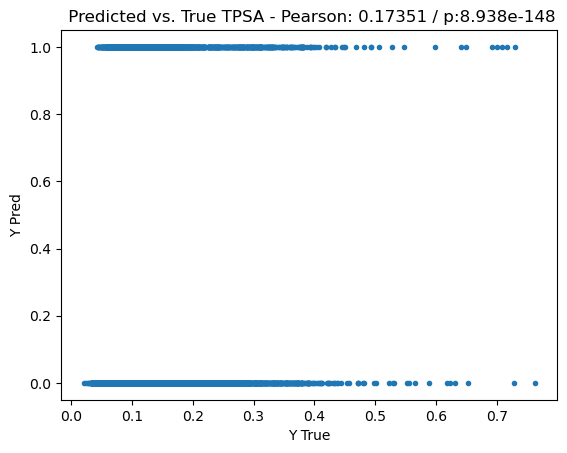

In [186]:
# fig = plt.figure(figsize=(6,6))
plt.plot(y_pred,y_test_np,  '.')
plt.title(f" Predicted vs. True TPSA - Pearson: {pearson_corr:.5f} / p:{pearson_p:.3e}")
plt.xlabel("Y True");
plt.ylabel("Y Pred");
# plt.xlim(1.775, 1.875)
# plt.xlim(1.775, 1.875)

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, 'Compounds')

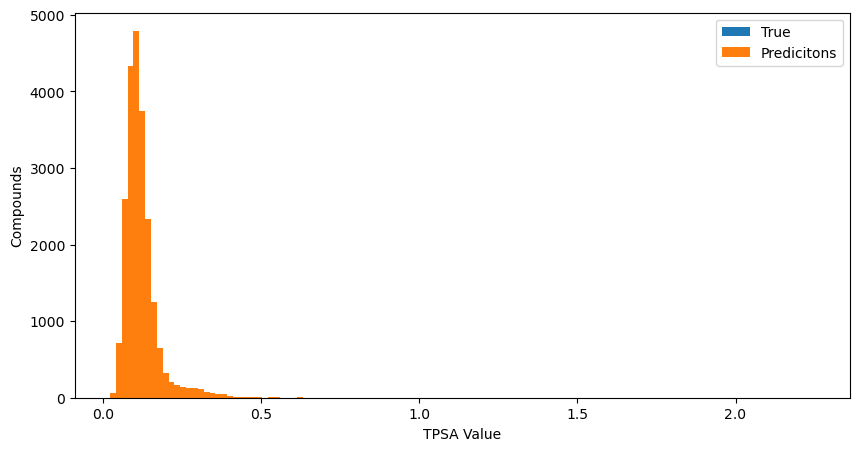

In [187]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 40
# fig, ax = plt.subplots()
 
# the histogram of the data

fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(y_test_np, num_bins, density=False, label = 'True', range=[1.5,2.25] )
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(y_pred, num_bins, density=False, label='Predicitons' )
plt.xlabel('TPSA Value')
plt.ylabel('Compounds')
plt.legend()
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

### plot ROC and Precision-Recall Curves

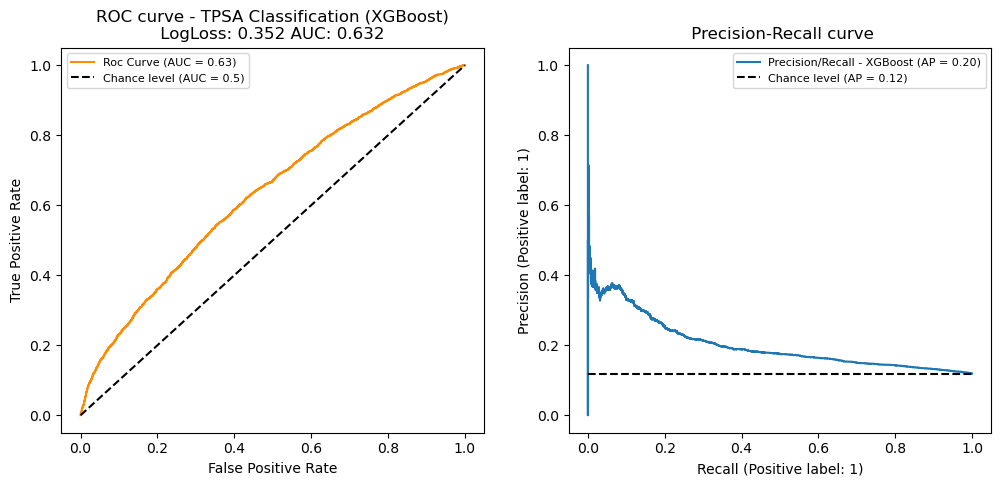

In [191]:
### from sklearn.metrics import RocCurveDisplay
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


roc_display = skm.RocCurveDisplay.from_predictions(
    y_test_np,
    y_pred, 
    name=f"Roc Curve",
    color="darkorange",
    plot_chance_level=True,
    ax = axes[0])

_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve - TPSA Classification (XGBoost)\n LogLoss: {metrics['logloss'] :0.3f} AUC: {metrics['roc_auc']:0.3f} ",
)
_ = roc_display.ax_.legend(fontsize=8);

# prec, recall, _ = skm.precision_recall_curve(y_test, predictions, pos_label=1)
# pr_display = skm.PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display = skm.PrecisionRecallDisplay.from_predictions(
    y_test_np, 
    y_pred, 
    name="Precision/Recall - XGBoost", 
    plot_chance_level=True,
    ax = axes[1])

_ = pr_display.ax_.set_title(" Precision-Recall curve");
_ = pr_display.ax_.legend(fontsize=8);
# plt.show()

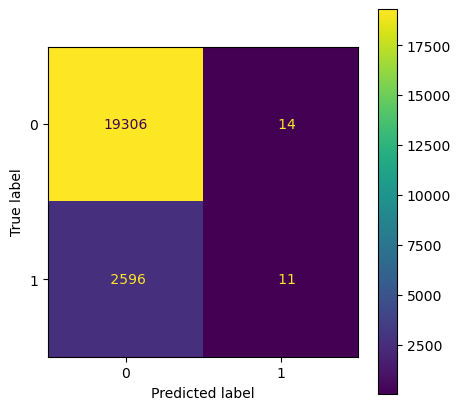

In [190]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
cm_display = skm.ConfusionMatrixDisplay.from_predictions(y_test_np, (y_pred >= 0.5), values_format="5d", ax = axes)

 # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
plt.show()

### Plot Feature Importance 

In [ ]:
# train_score = xgb_reg.score(train_X, train_y)
# val_score = xgb_reg.score(val_X, val_y)
# test_score = xgb_reg.score(test_X, test_y)

In [ ]:
print(f" R2 score - Training   : {train_score:0.6f}")
print(f" R2 score - Validation : {val_score:0.6f}")
print(f" R2 score - Test data  : {test_score:0.6f}")

In [ ]:
# fig = plt.figure(figsize=(20, 20))
# plt.yticks(fontsize = 12)
# ax = fig.add_subplot()
# ax.set_xlim(10,50)
ax = xgb.plot_importance(model_copy, max_num_features= None,  grid = False,  show_values = True, )
for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

In [ ]:
from graphviz import Source 
xgb.plot_tree(model_copy,num_tress=5)

In [ ]:
# model_copy.attributes()
model_copy.feature_names
model_copy.

In [ ]:
xgb.get_config()

# XGBoost Classification- Development 

- Need to convert Dask data frames to dask arrays in order to use data in parm grid search

In [ ]:
files = os.walk('./output_11102023')

for i in files :
    print(i)

### Read compound profiles

In [ ]:
profileInputFiles = './output_11102023/profiles/compound_profiles_2samples_*.csv'

In [ ]:
# del df_profiles
df_profiles = read_cell_profiles(profileInputFiles, rows = 200000)

In [ ]:
type(df_profiles)
df_profiles.head(3)
df_profiles.shape

### Training initialization

In [ ]:
 
metrics_hist = defaultdict(list)
metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]

# print(study_params)

In [ ]:
study_params = {  "booster"            : "gbtree",
                  "device"             : "gpu",
                  "objective"          :  "binary:logistic",
                  "eval_metric"        :  ["auc", "logloss"]
                  "learning_rate"      : 0.001,    ## eta
                  "max_depth"          : 10,
                  "max_leaves"         : 10,
                  "verbosity"          : 0,
                  "min_child_weight"   : 1, 
                  "scale_pos_weight"   : 7.89,
                  "gamma"              : 0.0001,  ## min split loss 
               }

In [ ]:
iter_files = make_cv_splits(df_profiles, n_folds=5, y_columns=y_columns)

In [ ]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 
# xgb.set_config(use_rmm = True, verbosity = 1)
# xgb.set_config()
# xgb.get_config()

### Beginning of loop

In [ ]:
(X_train,y_train), (X_test, y_test) = next(iter_files)

In [ ]:
logging.info(f"Building TRAINING/TEST DMatricies...")

d_train = xgb.dask.DaskDMatrix(client, X_train, y_train )
# logging.info(f"Building TRAINING DMatrix...Completed")

# logging.info(f"Building TEST DMatrix...")
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test )
logging.info(f"Building TRAINING/TEST DMatricies...Completed")

In [ ]:
# X_train.shape , X_test.shape, # y_train.shape , y_test.shape
booster_model = model['booster'] if model is not None else None

In [ ]:
logging.info(f"Training model...")
model = xgb.dask.train(
    None,
    {"verbosity": 0, "tree_method": "hist", **study_params},
    d_train,
    num_boost_round=10000,
    evals=[(d_train, "train"), (d_test, "test")],
    xgb_model = booster_model,
    verbose_eval=True,
    early_stopping_rounds = 50,
)
logging.info(f"Training model...Completed")

### Run on test data and plot results 

In [ ]:
model['booster'].best_iteration, model['booster'].best_score

In [ ]:
predictions = xgb.dask.predict(client, model,d_test).compute()

y_test_c = y_test.compute().to_numpy().squeeze()


In [ ]:
print(f" y_test_c   : {type(y_test_c)} \t\t\t shape: {y_test_c.shape}")
print(f" Predictions: {type(predictions)} \t\t\t shape: {predictions.shape}")
np.bincount(y_test_c)

In [ ]:
logging.info(f"Calculating metrics...")
# R2_score = skm.r2_score(y_true = y_test_c, y_pred = predictions)
# mse_score = skm.mean_squared_error(y_true = y_test_c, y_pred = predictions, squared=False,)
# metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
#                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
metrics = compute_classification_metrics(model, y_test_c, predictions)
logging.info(f"Calculating metrics...Completed")

In [ ]:
# print(y_test_c)
# print(predictions)
print()
print(f"    log_loss :  {metrics['logloss']:9.6f}")
print(f"    Accuracy :  {metrics['accuracy']:9.6f}")
print(f" Bal. Accrcy :  {metrics['bal_acc']:9.6f}")
print(f" Top 3 Score :  {metrics['top_k_acc']:9.6f}")
print(f"    F1 Score :  {metrics['F1_score']:9.6f}")
print(f"     Pearson :  {metrics['pearson_corr']:9.6f}          P : {pearson_p:9.4e}")
print()
print(f"   Training AUC :  {metrics['train_auc']:.6f}      Logloss : {metrics['train_logloss']:.6f}")
print(f" Validation AUC :  {metrics['val_auc']:.6f}      Logloss : {metrics['val_logloss']:.6f}")
print(f"       Test AUC :  {metrics['roc_auc']:.6f}      Logloss : {metrics['logloss']:.6f}")

In [ ]:
for key in metrics_keys:
    print(f" {key:20s}:    {metrics_hist[key]}")

In [ ]:
model['booster'].best_score
model['booster'].best_iteration

### plot results

In [ ]:
### from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(1, 3, figsize=(16, 5))


roc_display = skm.RocCurveDisplay.from_predictions(
    y_test_c,
    predictions, 
    name=f"Roc Curve",
    color="darkorange",
    plot_chance_level=True,
    ax = axes[0]
)
_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve - TPSA Classification (XGBoost)\n LogLoss: {metrics_hist['logloss'][-1]:0.3f}      AUC: {metrics_hist['roc_auc'][-1]:0.3f} ",
)
_ = roc_display.ax_.legend(fontsize=8);

# prec, recall, _ = skm.precision_recall_curve(y_test, predictions, pos_label=1)
# pr_display = skm.PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display = skm.PrecisionRecallDisplay.from_predictions(
    y_test_c, 
    predictions, 
    name="Precision/Recall - XGBoost", 
    plot_chance_level=True,
    ax = axes[1]
)
_ = pr_display.ax_.set_title(" Precision-Recall curve");
_ = pr_display.ax_.legend(fontsize=8);
cm_display = skm.ConfusionMatrixDisplay.from_predictions(y_test_c, (predictions >= 0.5), values_format="5d", ax = axes[2])

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
# plt.show()

In [ ]:
# del d_train, d_test
del model, predictions, pearson_p
del d_train, d_test, X_train, y_train, X_test, y_test, y_test_c

### End of loop

In [ ]:
print_metric_hist(metrics_hist)

In [ ]:
# type(model)
data = { 'mse_scores' : mse_scores_np,
         'R2_scores' : R2_scores_np}
    
with open(trainingMetrics, 'wb') as f: 
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(trainingMetrics, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
data